Using device: cuda


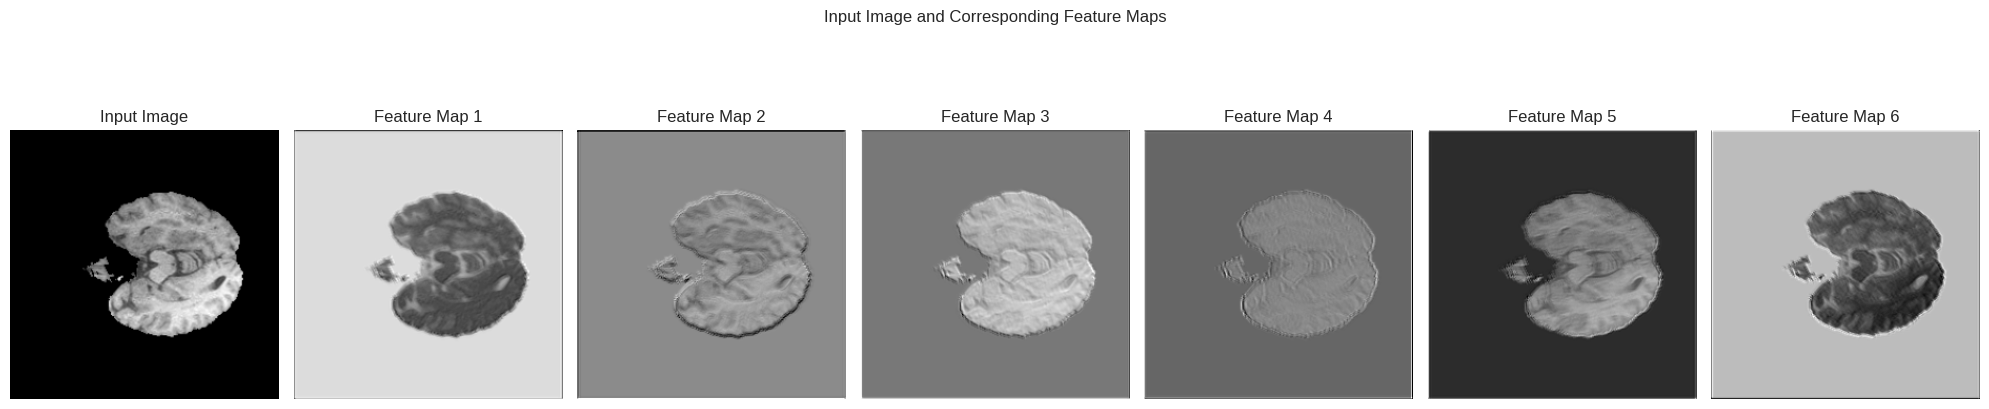

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 192, 256, 256])

Feature map statistics:
Mean: 0.0046
Std: 0.2259
Min: -0.6586
Max: 0.8914


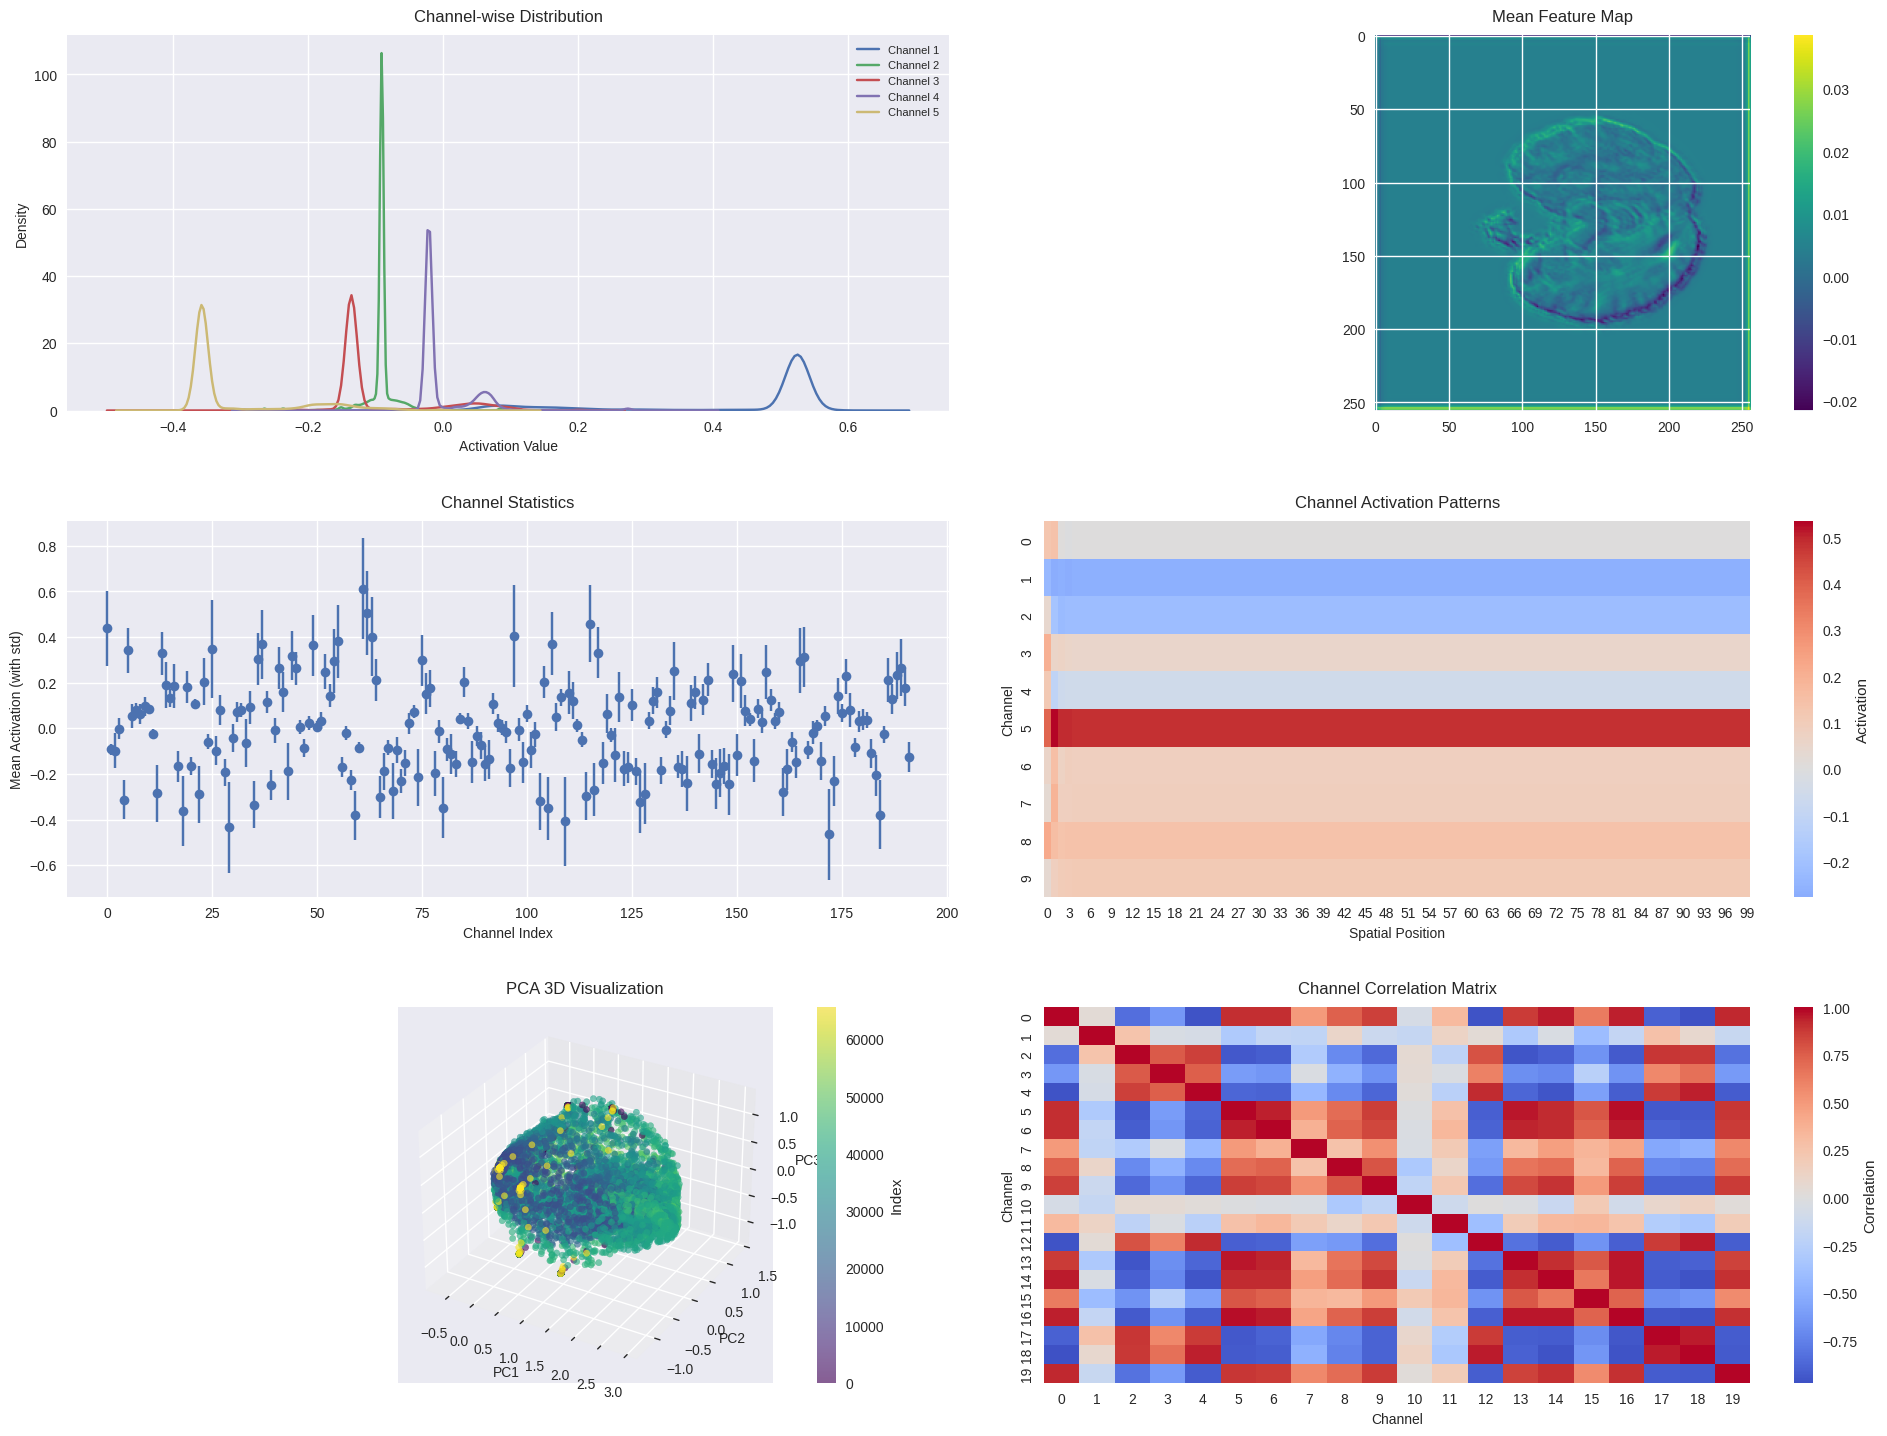


Latent Space Statistics:
Shape: (192, 256, 256)
Total dimensions: 12582912
Global mean: 0.0046
Global std: 0.2259
Min value: -0.6586
Max value: 0.8914

PCA Explained Variance Ratio:
[0.86247253 0.03212019 0.02796044]

Model Architecture:
MultiStageEncoder(
  (branches): ModuleList(
    (0): BranchBlock(
      (block1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (block2): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Re

In [12]:
import torch
import torch.nn as nn
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
import logging
import os

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress tensorflow warnings if any
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configure logging to suppress unnecessary messages
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Set seaborn style for better visualization
sns.set_style("whitegrid")
plt.style.use('seaborn')

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super(ConvBlock, self).__init__()
        
        # Calculate padding if 'same' is specified
        if padding == 'same':
            padding = kernel_size // 2
            
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        return self.conv(x)

class BranchBlock(nn.Module):
    def __init__(self, kernel_size, in_channels=1, out_channels=64, stride=1):
        super(BranchBlock, self).__init__()
        
        self.block1 = ConvBlock(in_channels, out_channels, kernel_size, stride)
        self.block2 = ConvBlock(out_channels, out_channels, kernel_size, stride)
        
    def forward(self, x):
        out1 = self.block1(x)
        out2 = self.block2(out1)
        return out2 + out1  # Skip connection

class MultiStageEncoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, num_branches=3):
        super(MultiStageEncoder, self).__init__()
        
        # Create parallel branches with different kernel sizes
        self.branches = nn.ModuleList([
            BranchBlock(kernel_size=3+2*i, in_channels=in_channels, out_channels=out_channels)
            for i in range(num_branches)
        ])
        
        # Final output dimension will be (batch_size, out_channels * num_branches, height, width)
        self.out_channels = out_channels * num_branches
        
    def forward(self, x):
        # Process through each branch
        branch_outputs = [branch(x) for branch in self.branches]
        
        # Concatenate along channel dimension
        return torch.cat(branch_outputs, dim=1)

class BraTSDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform
        
        # Load NIfTI file
        nifti_img = nib.load(self.file_path)
        self.data = nifti_img.get_fdata()
        
        # Normalize data
        self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())
        
    def __len__(self):
        return self.data.shape[2]  # Number of slices
        
    def __getitem__(self, idx):
        # Get 2D slice
        slice_data = self.data[:, :, idx]
        
        # Convert to torch tensor and add channel dimension
        slice_tensor = torch.FloatTensor(slice_data).unsqueeze(0)
        
        if self.transform:
            slice_tensor = self.transform(slice_tensor)
            
        return slice_tensor

def plot_input_and_features(input_image, feature_maps, num_maps=6, title="Input and Feature Maps"):
    """
    Plot the input image alongside its feature maps
    Args:
        input_image: Input tensor of shape (1, 1, H, W)
        feature_maps: Output tensor of shape (1, C, H, W)
        num_maps: Number of feature maps to display
        title: Title for the plot
    """
    num_maps = min(num_maps, feature_maps.shape[1])
    fig, axes = plt.subplots(1, num_maps + 1, figsize=(20, 5))
    
    # Plot input image
    axes[0].imshow(input_image[0, 0].detach().cpu(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Input Image')
    
    # Plot feature maps
    for i in range(num_maps):
        axes[i + 1].imshow(feature_maps[0, i].detach().cpu(), cmap='gray')
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f'Feature Map {i+1}')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def visualize_latent_space(latent_vector):
    """
    Create a comprehensive visualization of the latent space with multiple plots
    Args:
        latent_vector: Tensor of shape (C, H, W) - the output from the encoder
    """
    # Ensure no runtime warnings from numpy
    with np.errstate(divide='ignore', invalid='ignore'):
        # Convert to numpy and reshape
        latent_data = latent_vector.detach().cpu().numpy()
        original_shape = latent_data.shape
        flattened_data = latent_data.reshape(original_shape[0], -1)  # Reshape to (channels, height*width)
        
        # Create a figure with multiple subplots
        plt.close('all')  # Close any existing plots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Channel-wise distribution plot
        ax1 = fig.add_subplot(321)
        for i in range(min(5, original_shape[0])):  # Plot first 5 channels
            sns.kdeplot(data=flattened_data[i], label=f'Channel {i+1}', ax=ax1)
        ax1.set_title('Channel-wise Distribution', fontsize=12, pad=10)
        ax1.set_xlabel('Activation Value', fontsize=10)
        ax1.set_ylabel('Density', fontsize=10)
        ax1.legend(fontsize=8)
        
        # 2. 2D Feature map visualization (mean across channels)
        ax2 = fig.add_subplot(322)
        mean_activation = np.nanmean(latent_data, axis=0)  # Using nanmean to handle NaN values
        im = ax2.imshow(mean_activation, cmap='viridis')
        ax2.set_title('Mean Feature Map', fontsize=12, pad=10)
        plt.colorbar(im, ax=ax2)
        
        # 3. Channel activation statistics
        ax3 = fig.add_subplot(323)
        channel_means = np.nanmean(flattened_data, axis=1)
        channel_stds = np.nanstd(flattened_data, axis=1)
        ax3.errorbar(range(len(channel_means)), channel_means, yerr=channel_stds, fmt='o')
        ax3.set_title('Channel Statistics', fontsize=12, pad=10)
        ax3.set_xlabel('Channel Index', fontsize=10)
        ax3.set_ylabel('Mean Activation (with std)', fontsize=10)
        
        # 4. Activation heatmap for first few channels
        ax4 = fig.add_subplot(324)
        num_channels_show = min(10, original_shape[0])
        sns.heatmap(flattened_data[:num_channels_show, :100], 
                    ax=ax4, cmap='coolwarm', center=0, cbar_kws={'label': 'Activation'})
        ax4.set_title('Channel Activation Patterns', fontsize=12, pad=10)
        ax4.set_xlabel('Spatial Position', fontsize=10)
        ax4.set_ylabel('Channel', fontsize=10)
        
        # 5. PCA visualization (3D)
        ax5 = fig.add_subplot(325, projection='3d')
        if flattened_data.shape[0] > 3:
            try:
                pca = PCA(n_components=3)
                pca_result = pca.fit_transform(flattened_data.T)
                scatter = ax5.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                                   c=range(len(pca_result)), cmap='viridis', alpha=0.6)
                ax5.set_title('PCA 3D Visualization', fontsize=12, pad=10)
                ax5.set_xlabel('PC1', fontsize=10)
                ax5.set_ylabel('PC2', fontsize=10)
                ax5.set_zlabel('PC3', fontsize=10)
                plt.colorbar(scatter, ax=ax5, label='Index')
            except Exception as e:
                ax5.text(0.5, 0.5, 0.5, 'PCA failed', ha='center', va='center')
        
        # 6. Correlation matrix between channels
        ax6 = fig.add_subplot(326)
        num_channels_corr = min(20, original_shape[0])  # Limit to first 20 channels
        corr_matrix = np.corrcoef(flattened_data[:num_channels_corr])
        sns.heatmap(corr_matrix, ax=ax6, cmap='coolwarm', center=0, 
                   cbar_kws={'label': 'Correlation'})
        ax6.set_title('Channel Correlation Matrix', fontsize=12, pad=10)
        ax6.set_xlabel('Channel', fontsize=10)
        ax6.set_ylabel('Channel', fontsize=10)
        
        # Adjust layout to prevent overlap
        plt.tight_layout(pad=3.0)
        
        # Display the plot
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.show()
        
        # Print additional statistics
        print("\nLatent Space Statistics:")
        print(f"Shape: {original_shape}")
        print(f"Total dimensions: {np.prod(original_shape)}")
        print(f"Global mean: {np.nanmean(latent_data):.4f}")
        print(f"Global std: {np.nanstd(latent_data):.4f}")
        print(f"Min value: {np.nanmin(latent_data):.4f}")
        print(f"Max value: {np.nanmax(latent_data):.4f}")
        
        # If PCA was performed, print explained variance
        if flattened_data.shape[0] > 3:
            try:
                print("\nPCA Explained Variance Ratio:")
                print(pca.explained_variance_ratio_)
            except:
                print("\nPCA statistics not available")


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = MultiStageEncoder(in_channels=1, out_channels=64, num_branches=3).to(device)
model.eval()

# Dataset path (adjust this path to your data location)
file_path = "/kaggle/input/brats2020-nifti-format-for-deepmedic/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_025/BraTS20_Training_025_t1.nii"

# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

try:
    dataset = BraTSDataset(file_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Process a single batch
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = batch.to(device)
            
            # Get model output
            output = model(batch)
            
            # Display input and feature maps
            plot_input_and_features(batch, output, num_maps=6, 
                                title="Input Image and Corresponding Feature Maps")
            
            # Print shapes for verification
            print(f"Input shape: {batch.shape}")
            print(f"Output shape: {output.shape}")
            
            # Print feature map statistics
            print(f"\nFeature map statistics:")
            print(f"Mean: {output.mean().item():.4f}")
            print(f"Std: {output.std().item():.4f}")
            print(f"Min: {output.min().item():.4f}")
            print(f"Max: {output.max().item():.4f}")

            # Visualize latent space
            visualize_latent_space(output[0])
            
            break  # Only process one batch

    # Print model summary
    print("\nModel Architecture:")
    print(model)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal number of parameters: {total_params:,}")

except Exception as e:
    print(f"An error occurred: {str(e)}")

